# K-Means Clustering Model Training

## Define Constants

In [2]:
ART_DIR = "artifacts"
RANDOM_STATE = 42
ID_COL = "district_id"  # expected column name in artifacts/district_ids.csv

### Defining Parameters for Grid Search

* `K_GRID`
* `SEEDS`
* `N_INIT`. In scikit-learn, the `n_init` parameter in the `KMeans` method refers to the number of times the kmeans algorithm is run with different centroid seeds.

In [3]:
K_GRID = range(2, 13)   # try k = 2..12
SEEDS = range(10)       # 10 random seeds per k
N_INIT = 10             # KMeans restarts per fit

## Import Needed Libraries
* `silhouette_score`
* `calinski_harabasz_score`
* `davies_bouldin_score`

In [4]:
import os, json, itertools
import numpy as np
import pandas as pd
import joblib
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
)

## Helper Functions

In [5]:
def ensure_artifacts_dir():
    os.makedirs(ART_DIR, exist_ok=True)

### Load Feature Matricies

In [6]:

def load_X(variant: str) -> np.ndarray:
    """Load pre-scaled feature matrix saved by preprocess.
    Expects NPZ with key 'X' at artifacts/X_{variant}_scaled.npz.
    """
    path = f"{ART_DIR}/X_{variant}_scaled.npz"
    if not os.path.exists(path):
        raise FileNotFoundError(
            f"Could not find {path}. Run preprocess to produce it."
        )
    arr = np.load(path)
    if "X" not in arr:
        raise KeyError(f"'X' not found in {path}. Check how the array was saved.")
    X = arr["X"]
    if X.ndim != 2:
        raise ValueError(f"X must be 2D (n_samples, n_features). Got shape {X.shape}.")
    return X

### Load Row IDs

In [7]:
def load_ids() -> pd.DataFrame:
    """Load row identifiers aligned with X rows."""
    path = f"{ART_DIR}/district_ids.csv"
    if not os.path.exists(path):
        raise FileNotFoundError(
            f"Missing {path}. Preprocess should export this file including '{ID_COL}'."
        )
    ids = pd.read_csv(path)
    if ID_COL not in ids.columns:
        raise KeyError(
            f"Expected column '{ID_COL}' in {path}, found {ids.columns.tolist()}"
        )
    if ids[ID_COL].isnull().any():
        raise ValueError("district_ids.csv contains null IDs; fix upstream.")
    if not ids[ID_COL].is_unique:
        raise ValueError("district_ids.csv has duplicate IDs; ensure uniqueness.")
    return ids

## Diagnostics

In [8]:
def print_cluster_sizes(labels: np.ndarray):
    uniq, cnts = np.unique(labels, return_counts=True)
    sizes = dict(zip(uniq.tolist(), cnts.tolist()))
    print("Cluster sizes:", sizes)

## Grid Search
* The `load_X(variant)` helper function is called to load the feature matrix for the selected variant (racial features included vs racial features excluded).
* We iterate through each k and seed and fit Kmeans with n_init restarts, predict labels, and compute Silouette score, Calinski-Harbasz, Davies-Bouldin, and inertia.
* We build a per_fit DataFrame.

In [9]:
def k_search(variant: str, k_grid=K_GRID, seeds=SEEDS, n_init=N_INIT):
    """
    Try multiple k and random seeds; compute metrics; aggregate and pick best k by
    mean silhouette. Returns (raw_df, agg_sorted_df, chosen_k).
    Persists `artifacts/ksearch_{variant}.csv` with the aggregated table.
    """
    X = load_X(variant)
    if X.shape[0] < max(k_grid):
        raise ValueError(
            f"Need n_samples >= max(k_grid). n_samples={X.shape[0]}, max_k={max(k_grid)}"
        )

    rows = []
    for k, rs in itertools.product(k_grid, seeds):
        km = KMeans(n_clusters=k, random_state=rs, n_init=n_init)
        labels = km.fit_predict(X)
        # Metrics
        try:
            sil = float(silhouette_score(X, labels))
        except Exception:
            sil = float("nan")
        try:
            ch = float(calinski_harabasz_score(X, labels))
        except Exception:
            ch = float("nan")
        try:
            db = float(davies_bouldin_score(X, labels))
        except Exception:
            db = float("nan")
        rows.append({
            "variant": variant,
            "k": int(k),
            "random_state": int(rs),
            "inertia": float(km.inertia_),
            "silhouette": sil,
            "calinski_harabasz": ch,
            "davies_bouldin": db,
            "n_samples": int(X.shape[0]),
            "n_features": int(X.shape[1]),
        })

    df = pd.DataFrame(rows)
    agg = (
        df.groupby("k", as_index=False)
          .agg(
              silhouette_mean=("silhouette", "mean"),
              silhouette_std=("silhouette", "std"),
              ch_mean=("calinski_harabasz", "mean"),
              db_mean=("davies_bouldin", "mean"),
              inertia_mean=("inertia", "mean"),
          )
    )

    # Choose by silhouette_mean desc; tie-break by lower db_mean, higher ch_mean
    agg_sorted = agg.sort_values(
        by=["silhouette_mean", "db_mean", "ch_mean"],
        ascending=[False, True, False]
    ).reset_index(drop=True)

    k_best = int(agg_sorted.iloc[0]["k"]) if len(agg_sorted) else None

    ensure_artifacts_dir()
    out_csv = f"{ART_DIR}/ksearch_{variant}.csv"
    agg_sorted.to_csv(out_csv, index=False)

    print(f"[{variant}] k-search complete. Top k by silhouette: {k_best}")
    print(agg_sorted.head(10))
    return df, agg_sorted, k_best

## Training at Chosen K

In [10]:
def train_variant_with_k(variant: str, k: int):
    """
    Train KMeans at specific k; save model, labels, and metadata.
    Outputs:
      - artifacts/kmeans_{variant}_k{k}.joblib
      - artifacts/clusters_{variant}_k{k}.csv
      - artifacts/trainmeta_{variant}_k{k}.json
    """
    ensure_artifacts_dir()
    X = load_X(variant)
    ids = load_ids()

    if len(ids) != X.shape[0]:
        raise ValueError(
            f"Row mismatch: ids={len(ids)} vs X={X.shape[0]}. Ensure preprocess alignment."
        )
    if X.shape[0] <= k:
        raise ValueError(
            f"n_samples={X.shape[0]} must be > k={k}. Lower k or feed finer-grain data."
        )

    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=N_INIT)
    labels = km.fit_predict(X)

    # Save model
    model_path = f"{ART_DIR}/kmeans_{variant}_k{k}.joblib"
    joblib.dump(km, model_path)

    # Save labels merged with IDs
    out_labels_path = f"{ART_DIR}/clusters_{variant}_k{k}.csv"
    out_ids = ids.copy()
    out_ids[f"cluster_{variant}_k{k}"] = labels
    out_ids.to_csv(out_labels_path, index=False)

    # Metrics
    inertia = float(km.inertia_)
    try:
        sil = float(silhouette_score(X, labels))
    except Exception:
        sil = float("nan")

    meta = {
        "variant": variant,
        "k": int(k),
        "random_state": int(RANDOM_STATE),
        "n_init": str(N_INIT),
        "inertia": inertia,
        "silhouette": sil,
        "n_samples": int(X.shape[0]),
        "n_features": int(X.shape[1]),
        "ids_file": f"{ART_DIR}/district_ids.csv",
        "X_file": f"{ART_DIR}/X_{variant}_scaled.npz",
        "model_file": model_path,
        "labels_file": out_labels_path,
        "id_col": ID_COL,
    }
    with open(f"{ART_DIR}/trainmeta_{variant}_k{k}.json", "w") as f:
        json.dump(meta, f, indent=2)

    print(f"[{variant}] k={k} | inertia={inertia:.3f} | silhouette={sil if sil==sil else 'NA'} | X={X.shape}")
    print_cluster_sizes(labels)

    return km, labels, meta

## Run End-to-End

### Search Over k for Both Variants

In [11]:
# 1) Search over k for both variants
_, full_agg, k_full = k_search("full", k_grid=K_GRID, seeds=SEEDS, n_init=N_INIT)
_, norace_agg, k_norace = k_search("norace", k_grid=K_GRID, seeds=SEEDS, n_init=N_INIT)

# If you prefer to override the discovered k for interpretability, uncomment:
# k_full = 5
# k_norace = 5

[full] k-search complete. Top k by silhouette: 5
    k  silhouette_mean  silhouette_std    ch_mean   db_mean  inertia_mean
0   5         0.281417        0.004457  16.132361  0.826625    128.576720
1   2         0.264854        0.006769  12.185404  1.497643    283.903409
2   4         0.260777        0.005450  15.640085  0.921576    159.663673
3  10         0.248399        0.020987  17.003552  0.848813     58.814226
4   3         0.247225        0.002133  15.166188  1.000849    203.574963
5  11         0.243806        0.021740  16.506333  0.800525     53.445373
6   9         0.243703        0.023518  16.765386  0.843089     67.651365
7   8         0.241486        0.004137  16.192246  0.848792     79.549289
8   6         0.235969        0.014844  16.295208  0.916962    107.204483
9   7         0.234142        0.019066  16.010766  0.878479     92.713130
[norace] k-search complete. Top k by silhouette: 3
    k  silhouette_mean  silhouette_std    ch_mean   db_mean  inertia_mean
0   3       

### Train Final Models at Chosen k

In [12]:
km_full, labels_full, meta_full = train_variant_with_k("full", k_full)
km_norace, labels_norace, meta_norace = train_variant_with_k("norace", k_norace)

[full] k=5 | inertia=128.600 | silhouette=0.2787602678607726 | X=(38, 10)
Cluster sizes: {0: 14, 1: 8, 2: 13, 3: 2, 4: 1}
[norace] k=3 | inertia=67.950 | silhouette=0.4175162643399957 | X=(38, 6)
Cluster sizes: {0: 17, 1: 20, 2: 1}


### PCA Scatter
For deeper visuals, use the evaluate notebook.
PCA scatter is done for a quick visual separation check

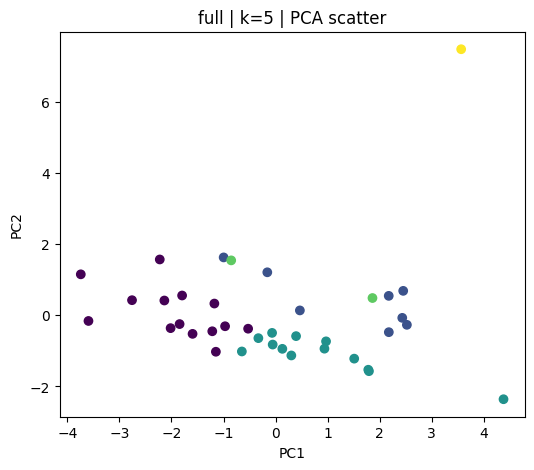

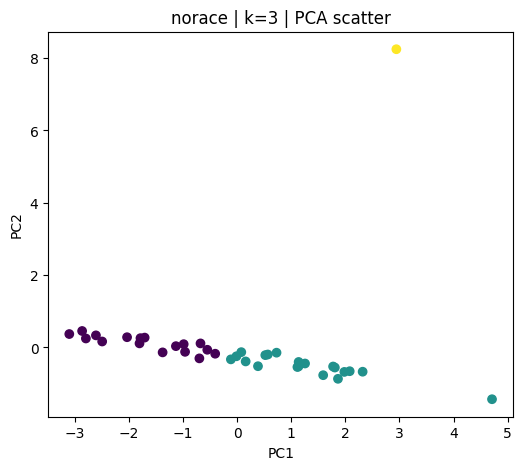

In [13]:



# %% [markdown]
# ## (Optional) Quick-look visuals
# For deeper visuals, use the **evaluate** notebook. Below are two light sanity checks.

# %%
# Optional: PCA scatter (for quick visual separation check). Keep minimal styling.
try:
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt

    def plot_pca_scatter(X, labels, title):
        p = PCA(n_components=2).fit_transform(X)
        plt.figure(figsize=(6,5))
        plt.scatter(p[:,0], p[:,1], c=labels)
        plt.title(title)
        plt.xlabel("PC1"); plt.ylabel("PC2")
        plt.show()

    # full
    X_full = load_X("full")
    plot_pca_scatter(X_full, labels_full, title=f"full | k={k_full} | PCA scatter")

    # norace
    X_nr = load_X("norace")
    plot_pca_scatter(X_nr, labels_norace, title=f"norace | k={k_norace} | PCA scatter")
except Exception as e:
    print("[visuals] Skipped PCA scatter:", e)


### References